In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [6]:
train_dir = r"C:\Users\ganta\Documents\N2\DATASET\DATASET\train"
test_dir  = r"C:\Users\ganta\Documents\N2\DATASET\DATASET\test"

all_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Remove 'Fear' and 'Disgust' (case-sensitive match)
skip = {"Fear", "Disgust", "Disguist"}   # added both spellings just in case
selected_classes = [c for c in all_classes if c not in skip]
print("Using classes:", selected_classes)

# -----------------------------
# 2) Datasets (train/val/test)
# -----------------------------
img_size = (224, 224)   # ResNet50 expects 224x224
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=selected_classes,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,   # split training into train+val
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=selected_classes,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=selected_classes,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

num_classes = len(selected_classes)
print("Number of classes:", num_classes)

Using classes: ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Found 11273 files belonging to 5 classes.
Using 9019 files for training.
Found 11273 files belonging to 5 classes.
Using 2254 files for validation.
Found 2834 files belonging to 5 classes.
Number of classes: 5


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
])


In [8]:
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(*img_size, 3)
)

base_model.trainable = False   # Freeze base initially

inputs = layers.Input(shape=(*img_size, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)        # ResNet50 preprocessing
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

# 5) Compute Class Weights
# -----------------------------
# From your dataset counts (train folder only)
class_counts = {
    "Angry": 705,
    "Happy": 4772,
    "Neutral": 2524,
    "Sad": 1982,
    "Surprise": 1290
}

import numpy as np

class_indices = {cls: idx for idx, cls in enumerate(selected_classes)}
y_train_labels = []
for cls, count in class_counts.items():
    y_train_labels += [class_indices[cls]] * count
y_train_labels = np.array(y_train_labels)

# Compute balanced weights
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

# # -----------------------------
# # 6) Compile
# # -----------------------------
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [9]:
import tensorflow as tf
from tensorflow.keras import callbacks, optimizers

# -----------------------------
# 1) Unfreeze last ResNet block
# -----------------------------
# Unfreeze last convolutional block of ResNet50
trainable = False
for layer in model.layers[-50:]:   # last ~50 layers (you can adjust)
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

print("Number of trainable layers:", sum([l.trainable for l in model.layers]))

# -----------------------------
# 2) Compile for fine-tuning
# -----------------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # small LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------------
# 3) Early Stopping + Checkpoint
# -----------------------------
ckpt_path = "resnet50_finetuned.keras"
cbs_ft = [
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# -----------------------------
# 4) Train with class weights
# -----------------------------
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,                     # early stopping will stop earlier if needed
    class_weight=class_weights,    # from your previous calculation
    callbacks=cbs_ft
)

# -----------------------------
# 5) Save weights after fine-tuning
# -----------------------------
model.save_weights("resnet50_finetuned_weights.h5")

Number of trainable layers: 8
Epoch 1/20
564/564 [==============================] - 478s 784ms/step - loss: 1.3633 - accuracy: 0.4298 - val_loss: 1.1981 - val_accuracy: 0.5408 - lr: 1.0000e-05
Epoch 2/20
564/564 [==============================] - 425s 752ms/step - loss: 0.9200 - accuracy: 0.6425 - val_loss: 0.7528 - val_accuracy: 0.7081 - lr: 1.0000e-05
Epoch 3/20
564/564 [==============================] - 430s 761ms/step - loss: 0.7429 - accuracy: 0.7098 - val_loss: 0.6733 - val_accuracy: 0.7467 - lr: 1.0000e-05
Epoch 4/20
564/564 [==============================] - 455s 805ms/step - loss: 0.6285 - accuracy: 0.7614 - val_loss: 0.7630 - val_accuracy: 0.7161 - lr: 1.0000e-05
Epoch 5/20
564/564 [==============================] - 448s 794ms/step - loss: 0.5448 - accuracy: 0.7909 - val_loss: 0.5610 - val_accuracy: 0.7902 - lr: 1.0000e-05
Epoch 6/20
564/564 [==============================] - 484s 857ms/step - loss: 0.4924 - accuracy: 0.8039 - val_loss: 0.6255 - val_accuracy: 0.7746 - lr: 1.0

In [23]:
# print("\n--- Phase 2: Fine-Tuning Last Layers ---")
# base_model.trainable = True

# # Unfreeze last 50 layers only
# for layer in base_model.layers[:-50]:
#     layer.trainable = False

# # Re-compile with smaller LR
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-5),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# ckpt_path2 = "resnet50_best_phase2.keras"
# cbs2 = [
#     callbacks.ModelCheckpoint(ckpt_path2, monitor="val_accuracy", save_best_only=True, mode="max"),
#     callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
#     callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# ]

# history2 = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=15,
#     callbacks=cbs2,
#     class_weight=class_weights
# )


--- Phase 2: Fine-Tuning Last Layers ---
Epoch 1/15
282/282 [==============================] - 290s 925ms/step - loss: 1.5323 - accuracy: 0.3386 - val_loss: 1.2755 - val_accuracy: 0.4978 - lr: 1.0000e-05
Epoch 2/15
282/282 [==============================] - 366s 1s/step - loss: 1.1356 - accuracy: 0.5464 - val_loss: 0.9428 - val_accuracy: 0.6526 - lr: 1.0000e-05
Epoch 3/15
282/282 [==============================] - 291s 1s/step - loss: 0.9586 - accuracy: 0.6292 - val_loss: 0.8617 - val_accuracy: 0.6863 - lr: 1.0000e-05
Epoch 4/15
282/282 [==============================] - 311s 1s/step - loss: 0.8502 - accuracy: 0.6697 - val_loss: 0.7957 - val_accuracy: 0.7169 - lr: 1.0000e-05
Epoch 5/15
282/282 [==============================] - 324s 1s/step - loss: 0.7711 - accuracy: 0.6973 - val_loss: 0.8681 - val_accuracy: 0.6943 - lr: 1.0000e-05
Epoch 6/15
282/282 [==============================] - 345s 1s/step - loss: 0.6951 - accuracy: 0.7249 - val_loss: 0.7067 - val_accuracy: 0.7520 - lr: 1.0000

In [16]:
# 6) Callbacks
# -----------------------------
#ckpt_path = "resnet50_best.keras"
#cbs = [
#    callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max"),
#callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
#    callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
#]


In [17]:
# -----------------------------
#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=20,
#    callbacks=cbs,
#    class_weight=class_weights   # <--- HERE
#)

# Save weights after training
#model.save_weights("resnet50_weights.h5")

Epoch 1/20
282/282 [==============================] - 391s 1s/step - loss: 1.6013 - accuracy: 0.3811 - val_loss: 1.3532 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 2/20
282/282 [==============================] - 332s 1s/step - loss: 1.3367 - accuracy: 0.4875 - val_loss: 1.0650 - val_accuracy: 0.6020 - lr: 0.0010
Epoch 3/20
282/282 [==============================] - 331s 1s/step - loss: 1.2710 - accuracy: 0.5129 - val_loss: 1.2043 - val_accuracy: 0.5408 - lr: 0.0010
Epoch 4/20
282/282 [==============================] - 332s 1s/step - loss: 1.2359 - accuracy: 0.5216 - val_loss: 1.1423 - val_accuracy: 0.5572 - lr: 0.0010
Epoch 5/20
282/282 [==============================] - 327s 1s/step - loss: 1.2117 - accuracy: 0.5320 - val_loss: 1.0576 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 6/20
282/282 [==============================] - 331s 1s/step - loss: 1.1996 - accuracy: 0.5376 - val_loss: 1.0978 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 7/20
282/282 [==============================] - 391s 1s/st

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

 76/178 [===========>..................] - ETA: 13s - loss: 0.3644 - accuracy: 0.8914 

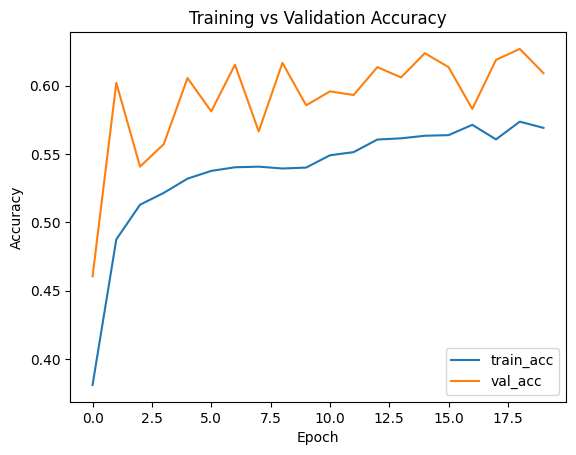

In [25]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

89/89 [==============================] - 21s 201ms/step

Classification Report:

              precision    recall  f1-score   support

       Angry       0.70      0.76      0.73       162
       Happy       0.95      0.78      0.86      1185
     Neutral       0.69      0.76      0.72       680
         Sad       0.66      0.83      0.73       478
    Surprise       0.81      0.80      0.80       329

    accuracy                           0.79      2834
   macro avg       0.76      0.79      0.77      2834
weighted avg       0.81      0.79      0.79      2834



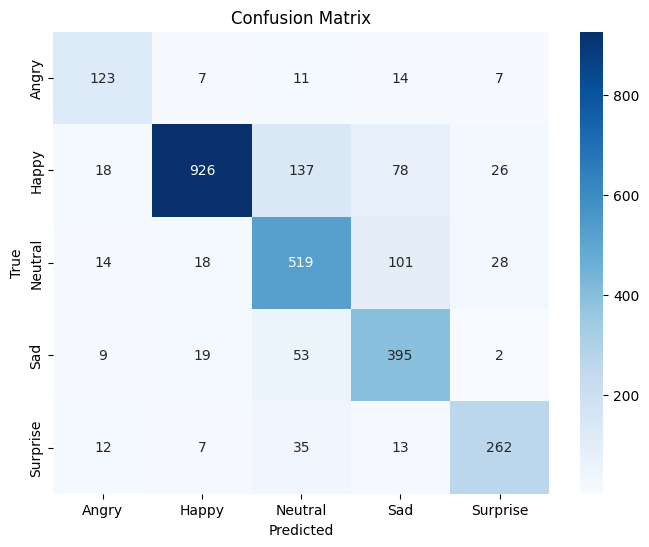

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1) Get Predictions on Test Set
# -----------------------------
y_true = []
y_pred = []

# Collect true labels
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Predict
pred_probs = model.predict(test_ds)
y_pred = np.argmax(pred_probs, axis=1)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -----------------------------
# 2) Classification Report
# -----------------------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=selected_classes))

# -----------------------------
# 3) Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()